In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# The Data

The data is generated data on generated used car sales data: 
https://www.kaggle.com/datasets/conorsully1/pdp-and-ice-plots

My goal with this data set it to predict car_type as accurately as possible through basic Machine Learning techniques. I did this with the aim of learning how to analyze data and make choices on which features/variables to include in the final model: a logistic regression classification model.

In [2]:
car_df = pd.read_csv('PDP_ICE_fixed.csv')
print(car_df.shape)
print(list(car_df.columns))

(1000, 6)
['owner_age', 'car_age', 'km_driven', 'repairs', 'car_type', 'price']


In [3]:
car_df.head()

,owner_age,car_age,km_driven,repairs,car_type,price
0,23,2.17,25142.768002,24,0,4077
1,26,18.92,120164.547502,17,0,2804
2,35,24.90,90244.499657,13,0,4432
3,34,1.93,15384.326615,18,0,5340
4,67,6.88,32319.146178,19,0,4053


# Input Variables


1 - owner_age: Age of the previous owner in years (numeric)

2 - car_age: Age of car at time of sale in years (numeric)

3 - km_driven: Distance driven at time of sale in kilometers (numeric)

4 - repairs: The number of times the car has been serviced/repaired (numeric)

5 - price: The $ price the second hand car was sold for (numeric)

# Predict Variable

y - car_type: A normal (0) car or a classic (1) car



# Data exploration/cleaning
First, we want a general overview of the data, just to see what we are working with.

In [4]:
car_df.describe()

,owner_age,car_age,km_driven,repairs,car_type,price
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,46.152000,20.59965,82377.836218,12.807000,0.187000,4354.076000
std,16.866576,11.28514,49873.724305,7.395569,0.390107,1960.881333
min,18.000000,1.00000,14738.735614,0.000000,0.000000,-1543.000000
25%,32.000000,10.72750,42881.726662,6.000000,0.000000,3048.000000
50%,46.000000,20.87500,70263.224727,13.000000,0.000000,4310.500000
75%,61.000000,30.29000,111688.819188,19.000000,0.000000,5758.250000
max,75.000000,39.99000,239619.058017,25.000000,1.000000,10523.000000


Here we can see a few things, such as the fact that the minimum price is negative. This is not acceptable, because this price
suggests that something outside of the table records was exchanged for the car, or the observation is an error. Thus we will
have to delete all rows with negative price values. We can do this by seperating them out from the rest of the data and recording the index number.

In [5]:
neg_price = car_df[car_df['price'] < 0]
print(neg_price)

     owner_age  car_age      km_driven  repairs  car_type  price
83          71    33.05  146812.303543       25         0   -105
176         47    36.43  206449.243503       22         0   -150
233         61    35.96  196141.184273       25         0   -831
265         46    32.01  159440.442718       24         0   -413
318         66    39.44  210298.233866       24         0  -1543
426         71    39.61  163016.846389       23         0   -149
505         30    37.55  220271.981320       21         0   -637
536         43    35.77  180058.997582        1         0    -45
644         69    38.82  215258.425790       23         0   -591
647         22    39.74  218753.398351       19         0   -537
648         56    38.27  160460.204162       24         0   -288
663         43    39.65  181559.206988       24         0   -580
819         37    36.23  191016.075846       25         0   -321


We can now use the row index values to delete these values from the dataset and then reset the index (and also drop any duplicate values while we're at it).

In [6]:
car_df.drop(car_df[car_df['price'] < 0].index, inplace=True)
car_df.info()

# Reseting indicies
car_df = car_df.drop_duplicates()
car_df = car_df.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   owner_age  987 non-null    int64  
 1   car_age    987 non-null    float64
 2   km_driven  987 non-null    float64
 3   repairs    987 non-null    int64  
 4   car_type   987 non-null    int64  
 5   price      987 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 54.0 KB


Now that we have dropped the negative sale values and reset our index, we can begin with exploratory data analysis.

Exploratory Data Analysis
================================================================


In [7]:
display(car_df)

,owner_age,car_age,km_driven,repairs,car_type,price
0,23,2.17,25142.768002,24,0,4077
1,26,18.92,120164.547502,17,0,2804
2,35,24.90,90244.499657,13,0,4432
3,34,1.93,15384.326615,18,0,5340
4,67,6.88,32319.146178,19,0,4053
...,...,...,...,...,...,...
982,50,20.87,79052.936636,0,1,4394
983,32,4.29,33727.348590,15,0,5408
984,62,12.43,30398.468612,9,0,6426
985,65,28.53,174801.168085,19,0,747


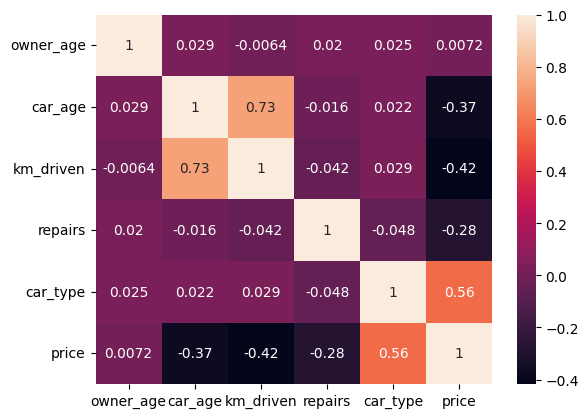

In [8]:
heatmap = sns.heatmap(car_df.corr(), annot=True)

Our features km_driven and car_age are highly correlated with respect to each other, and are both decently negatively correlated
with price. I think that there may be a sort of over-representation of their negative effects when we build a model, and so this
will need to be accounted for when model building.

I will dive into the high correlations before I begin to model how to predict car_type.

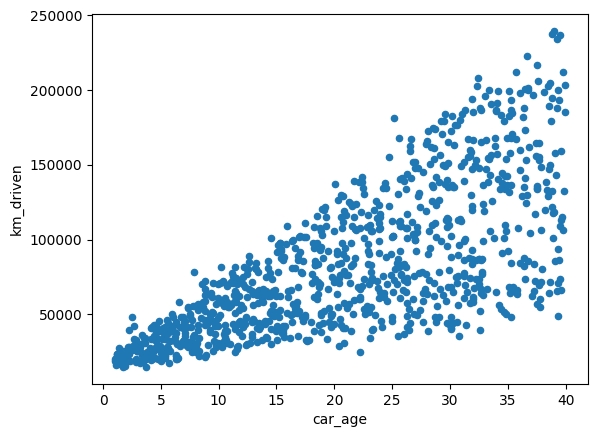

In [9]:
car_df.plot(x="car_age", y="km_driven", kind="scatter")
plt.show()

This is interesting. It seems like the variation in km_driven varies the greater the car age. This suggests that there may be
an auxillary factor causing this increase in variation as the car ages. I think this is car_type. 

I will run a linear regression that predicts price, just to investigate a bit further

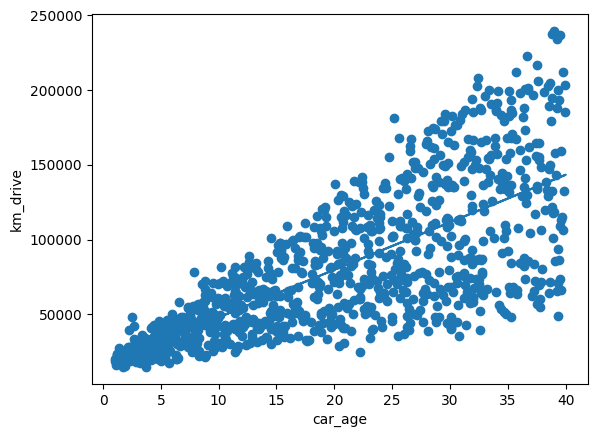

In [10]:
X = car_df.iloc[:, 1].values.reshape(-1, 1)
Y = car_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()
reg_ct_p = linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X, Y)
plt.xlabel("car_age")
plt.ylabel("km_drive")
plt.plot(X, Y_pred)
plt.show()

In [11]:
# Function that provides basic regression summary
def regression_results(y_true, y_pred, reg_num=1):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance, 4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error, 4))
    print('r ^ 2: ', round(r2, 4))
    print('Adjusted r ^ 2', (1 - ((1 - r2) * (len(car_df) - 1)) / (len(car_df) - reg_num - 1)))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))

regression_results(Y, Y_pred, 1)

explained_variance:  0.5358
mean_squared_log_error:  0.1471
r ^ 2:  0.5358
Adjusted r ^ 2 0.5353669875162723
MAE:  25315.786
MSE:  1095334708.1823


As you can see above, the regression results indicate that about 53% of the variation of km_driven is based on car_age.

The error is not homoskedastic. It is heteroskedastic; it does not lie within a constant range. This means that our ability to
to assess their cumulative influence in a model containing both of these factors will go down the greater the car_age and/or the more km_driven.

Now I will move on to examining based on price, since it is associated with many high correlations across the other features

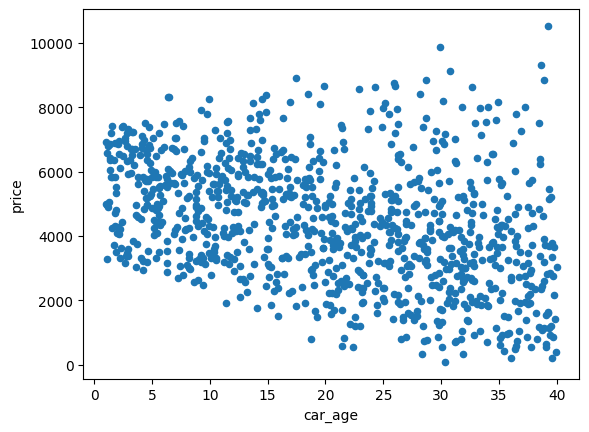

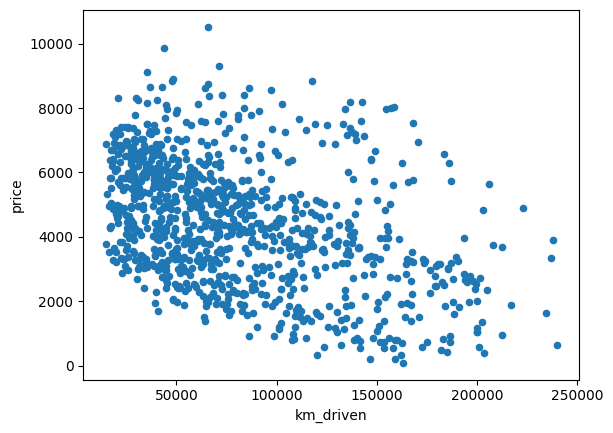

In [12]:
car_df.plot(x="car_age", y="price", kind="scatter")
car_df.plot(x="km_driven", y="price", kind="scatter")
plt.show()

These scatter plots reinforce the idea that car_age and km_driven have a similar effect on price, and when combined with the
aforementioned km_driven over car_age plot it indicates to me that these might distort our model building efforts.

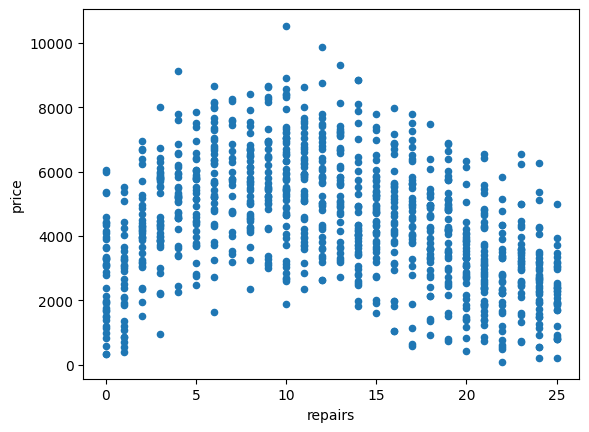

In [13]:
car_df.plot(x="repairs", y="price", kind="scatter")
plt.show()

This has a seemingly exponential distribution, as the value of the cars seems to trend upwards until around 10 repairs,
and then it begins to fall. It is sort of like an arch, so perhaps a polynomial regression would fit it the best. Unfortunately, the amount of variation over the course of the model from any such regression line would probably greatly diminish the utility of investigating such a relationship further.

# Exploration of car_type

Now that I've investigated the highly correlated features, I will to continue to the main point of this exercise; to train a model to predict car_type

We can begin by seperating the two categories and comparing basic measurements

In [14]:
car_df.groupby('car_type').mean()

,owner_age,car_age,km_driven,repairs,price
car_type,,,,,
0,45.883750,20.265400,80305.543541,12.862500,3907.528750
1,46.967914,20.881283,83870.934976,11.962567,6600.229947


There is a massive difference in price between classic-cars(1) and non-classic-cars(0).

The mean owner_age of those who own classic-cars(1) is roughly 1.1 years older than those who don't, which makes sense and is 
most likely due to factors such as nostalgia. 

There is also a small increase in car_age with respect to classic cars, which also makes sense as classic cars probably tend to be older. 

One suprising aspect of the data when split on car_type is that km_driven is higher on average with respect to classic-cars(1), while average amount of repairs on classic-cars(1) is lower than on non-classic-cars(0). This is probably due to a ton of factors, including the reason for and quality of the repair(s), which we lack data on.

In [15]:
# For non-classic-cars
car_df[car_df['car_type'] == 0].describe()

,owner_age,car_age,km_driven,repairs,car_type,price
count,800.000000,800.000000,800.000000,800.0000,800.0,800.000000
mean,45.883750,20.265400,80305.543541,12.8625,0.0,3907.528750
std,17.031231,11.218741,47792.002637,7.3715,0.0,1615.197756
min,18.000000,1.000000,14738.735614,0.0000,0.0,92.000000
25%,31.000000,10.392500,42904.888459,7.0000,0.0,2767.750000
50%,46.000000,20.670000,68304.033140,13.0000,0.0,3923.500000
75%,61.000000,29.935000,108396.836397,19.0000,0.0,5171.750000
max,75.000000,39.990000,239619.058017,25.0000,0.0,7401.000000


In [16]:
# For classic-cars
car_df[car_df['car_type'] == 1].describe()

,owner_age,car_age,km_driven,repairs,car_type,price
count,187.000000,187.000000,187.000000,187.000000,187.0,187.000000
mean,46.967914,20.881283,83870.934976,11.962567,1.0,6600.229947
std,16.203977,11.104877,51963.163695,7.185236,0.0,1368.871093
min,18.000000,1.150000,14742.995172,0.000000,1.0,3350.000000
25%,34.000000,11.950000,41601.902364,6.000000,1.0,5640.000000
50%,49.000000,20.870000,70766.263969,12.000000,1.0,6689.000000
75%,61.000000,30.115000,119274.238434,18.000000,1.0,7546.500000
max,75.000000,39.760000,237578.603778,25.000000,1.0,10523.000000


Price continues to convince me that it will be a major factor in our model, based on simply observing the difference between
the standard deviations and the centers of the distributions (means).

I will now delve more into the nature of the variable we want to train a model to predict for: car_type

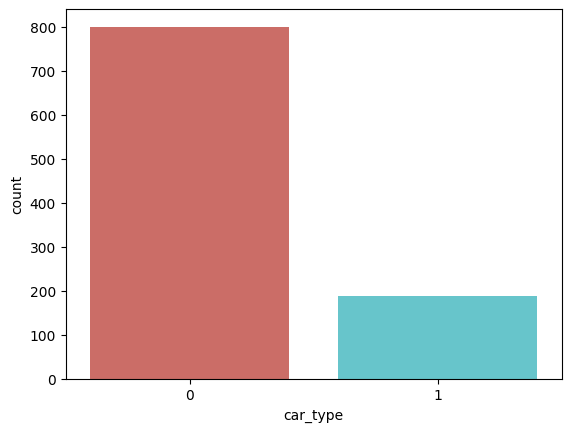

In [17]:
car_df['car_type'].value_counts()
sns.countplot(x='car_type', data=car_df, palette='hls')
plt.show()

In [18]:
not_classic = len(car_df[car_df['car_type'] == 0])
classic = len(car_df[car_df['car_type'] == 1])

pct_not_classic = not_classic / (not_classic + classic)
pct_classic = classic / (not_classic + classic)

print('non-classic car =~ {:.1f}%'.format(pct_not_classic * 100, 4))
print('classic car: =~ {:.1f}%'.format(pct_classic * 100, 4))

non-classic car =~ 81.1%
classic car: =~ 18.9%


As you can see above, the count of non-classic-cars(0) is much greater than the count of classic-cars(1). This is a major class
imbalance, and it may lead to an inability for our model to accurately represent our classic-cars(1). If it does, this would be because we are biasing the model towards non-classic-cars(0).

Now I will continue on to examining these differences based on classic-cars vs non-classic-cars.

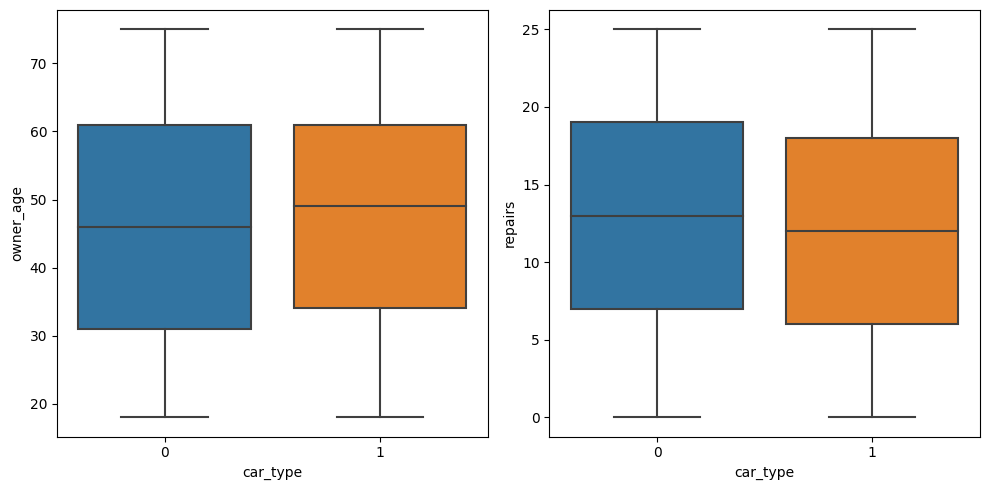

In [19]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)

ar_6 = sns.boxplot(x=car_df['car_type'], y=car_df['owner_age'])
fig.add_subplot(1, 2, 2)

ar_6 = sns.boxplot(x=car_df['car_type'], y=car_df['repairs'])

plt.tight_layout()
plt.show()

In both cases, the mean is noticeably different between classic-cars(1) and non-classic-cars(0) both with respect to owner_age and with respect to repairs. This suggests to me that these features will probably be included in our end model.

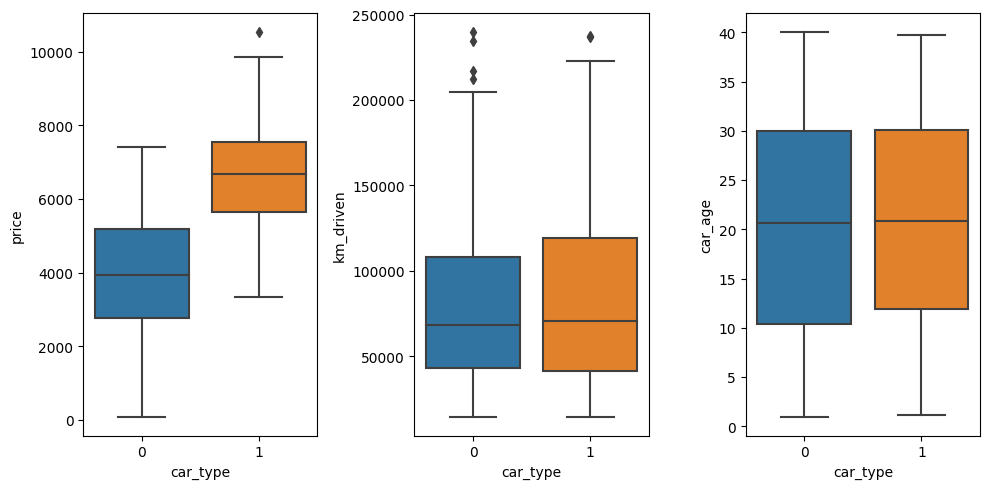

In [20]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 3, 1)

ar_6 = sns.boxplot(x=car_df['car_type'], y=car_df['price'])
fig.add_subplot(1, 3, 2)

ar_6 = sns.boxplot(x=car_df['car_type'], y=car_df['km_driven'])
fig.add_subplot(1, 3, 3)

ar_6 = sns.boxplot(x=car_df['car_type'], y=car_df['car_age'])

plt.tight_layout()
plt.show()

As we observed earlier, the large difference in the mean in price based on car_type is very clear, and the relatively tighter distributions for both classic-cars(1) and non-classic-cars(0) present when making the comparison between the price indicates to me that it will be a big contributor to our model's accuracy (or potential lacktherof).

Our difference between classic/non-classic cars with respect to both km_driven and car_age is not very noticeable. Perhaps they will be significant factors in the model, perhaps not.

Side note start
================================================================


Update: I will not use SMOTE as it induces a biased and innacurate result. I may return to this and attempt
to use it later, however for now I will disregard it.

I will explain both why I won't use SMOTE and how I was introduced to it through one of the many, many sources I used to as a reference for the structure of this project.

Reference: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

First I had to find out: What is SMOTE?

SMOTE: Synthetic Minority Oversampling Technique - "an oversampling method commonly used to solve class imbalance problems. It aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesises new minority instances between existing minority instances."

Source: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

From what I understand, SMOTE should not be used before the test-train split, because doing so distorts the model building process. 

What I gathered from further research: a crude explanation as to what SMOTE does is that it adds artificial observations that lie within the bounds of the values in our dataset, and is a form of "naive sampling". 

Due to the fact that it gleans from the bounds of our dataset, models built using SMOTE can become prone to overfitting for the existing and artificial data rather than evaluating real data. Basically, the model will get good at categorizing based on data points that already exist, but potentially less versatile/accurate when evaluating new data with observations that do not lie within the bounds of the values of the existing data.

In the article that I was most closely following to structure this project, the author used SMOTE before the test-train split.

It seems like the best way to use SMOTE is: 
1. always after the test-train split
2. when it is paired with a downsampling method

For these aforementioned reasons, I decided to forgo using SMOTE in this project.

Side note end
================================================================

# Recursive Feature Elimination 


Now I will move on to step one of our logisitc regression model building process RFE: Recursive Feature Elimination

RFE allows for quick evaluation of the significance of each of our features to predicting car_type, which makes it a great way to determine what to include and what to drop in our final model.

In [21]:
from sklearn import datasets
from sklearn.feature_selection import RFE
logreg = LogisticRegression()
rfe = RFE(logreg)

X = car_df.loc[:, car_df.columns != 'car_type']
y = car_df.loc[:, car_df.columns == 'car_type']

rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print(X.columns)

[False  True False  True False]
[3 1 4 1 2]
Index(['owner_age', 'car_age', 'km_driven', 'repairs', 'price'], dtype='object')


RFE suggests that in this order, importance in descending order: car_age/repairs, owner_age, price, km_driven
Ranking km_driven as the worst of our features is not suprising, considering that it is heavily correlated with car_age. 

What is suprising is that car_age itself is not lower in the rankings, however this may be explainable by reasoning that car_age (time) is independent of km_driven, however km_driven is not necessarily independent of car_age, hence their different rankings.

# Implementing and revising the model

In [22]:
import statsmodels.api as sm
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.445956
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.081     
Dependent Variable: car_type         AIC:              890.3173  
Date:               2022-11-08 19:09 BIC:              914.7907  
No. Observations:   987              Log-Likelihood:   -440.16   
Df Model:           4                LL-Null:          -479.13   
Df Residuals:       982              LLR p-value:      4.7380e-16
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
owner_age     -0.0419    0.0049  -8.6284  0.0000  -0.0514  -0.0324
car_age       -0.0209    0.0113  -1.8427  0.0654  -0.0430   0.

Both km_driven and car_age may need to be removed, but I suspect that their representations are being somewhat distorted by their high correlation with each other.

I will drop km_driven as it has a much higher P value than car_age and it ranked lowest when we utilized RFE.

In [23]:
cols = ['owner_age', 'car_age', 'repairs', 'price'] 
X = car_df[cols]
y = car_df['car_type']
X.shape

(987, 4)

In [24]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.445982
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.081     
Dependent Variable: car_type         AIC:              888.3682  
Date:               2022-11-08 19:09 BIC:              907.9469  
No. Observations:   987              Log-Likelihood:   -440.18   
Df Model:           3                LL-Null:          -479.13   
Df Residuals:       983              LLR p-value:      8.6706e-17
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
owner_age     -0.0418    0.0048  -8.6692  0.0000  -0.0512  -0.0323
car_age       -0.0188    0.0068  -2.7846  0.0054  -0.0320  -0.

This model seems to confirm my suspicions. Our feature car_age was definitely being distorted by km_driven, and was not actually rejectable. All of the other features are significant as well, so I will keep all of these features and move on to building the final model.

In [25]:
cols = ['owner_age', 'repairs', 'price'] 
X = car_df[cols]
y = car_df['car_type']
X.shape

(987, 3)

# Logisitic Regression Model Fitting
Now I will model fit using sklearn with the features listed above

In [26]:
cols = ['owner_age', 'car_age', 'repairs', 'price']
X = car_df[cols]
y = car_df['car_type']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.92
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       237
           1       0.95      0.65      0.77        60

    accuracy                           0.92       297
   macro avg       0.93      0.82      0.86       297
weighted avg       0.92      0.92      0.92       297



Our model is actually suprizingly accurate at 92%, and it seems to have actually managed to capture a great amount of the car_type = 1 despite having a relatively small proportion of observations to train off of compared to those with car_type = 0.

# Confusion matrix

In [27]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[235   2]
 [ 21  39]]


Just for clarification, the structure and labels above:

[ [TP , FP]

 [FN , TN] ]


TP: True positives - we classified 235 non-classic-cars(0) as non-classic-cars(0).                                        

FP: False positive - we misclassified 2 non-classic-cars(0) as classic-cars(1).                                     

FN: False negative - we misclassified 21 classic-cars(1) as non-classic-cars(0).


TN: True negative - we classified 39 classic-cars(1) as classic-cars(1).  

Lastly, we will use ROC-AUC comparison to visualize the accuracy of the model

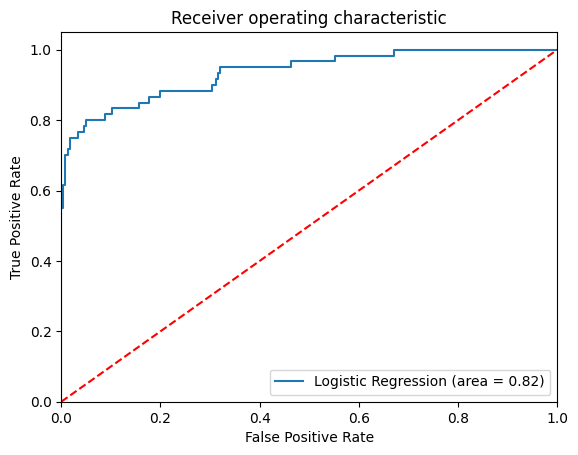

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Conclusion

Through utilizing data cleaning, data visualization, statisitics knowledge, and building a logistic regression, we were able to achieve a 92% accuracy rating for our classification model.

In [29]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[235   2]
 [ 21  39]]


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       237
           1       0.95      0.65      0.77        60

    accuracy                           0.92       297
   macro avg       0.93      0.82      0.86       297
weighted avg       0.92      0.92      0.92       297



The model's main deficiency is this 65% recall. The difference in f1-score can probably be attributed to the imbalance of the classification group, as well as the simple modeling method.

I think that this may be able to be improved utilizing more advanced methods such as weighting (the first thing I would try is weighting the price), other classification methods such as random forest, or techniques such as grid search and gradient boosting.

I will use these methods in future projects where the implementation of these methods has been done before by people more experienced than I am (such as a popular kaggle dataset) so that I can learn how to utilize them properly. I also want to work on a dataset that has a wider range of Input variables than this one.

For a basic model, and given the constraints of our group size, I think that our logistic regression model worked very well.